In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
from package_LAB import LL_RT, PID_RT, IMCTuning

from importlib import reload
package_DBR = reload(package_DBR)
package_LAB = reload(package_LAB)

# Process constants

In [2]:
# from MV

# automatic
Kp = 0.48305278277951064
T1p = 159.84828454194727
T2p = 11.44559902845228
thetap = 4.009584499836511

# van der Grinten
#Kp = 0.44
#T1p = 7.38
#T2p = 79.31
#thetap = 20.62


In [3]:
# from DV

# automatic
Kd = 0.4307501025499605
T1d = 157.77345895847023
T2d = 53.272586489684905
thetad = 12.645547269207029



# Simulation constants

In [4]:
TSim = 2500
Ts = 1
N = int(TSim/Ts) + 1



In [5]:
# Working point
MV0 = 50
DV0 = 50
PV0 = 62.2

In [12]:
gamma = 0. # Lower = more aggressive
Kc,Ti,Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print("Kc : ",Kc,", Ti : ", Ti,", Td : ", Td)

Kc :  2.6886934328401573 , Ti :  171.29388357039954 , Td :  10.680821358698136


In [7]:
alpha = 1
#Kc= 2.5
MVMin = 0
MVMax = 100

# Input signals 

In [8]:
settings = 'FF' 


if settings == 'Man':
    #  OLP, no FF
    ManPath = {0: True,TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, TSim: PV0} 
    DVPath = {0: DV0, 1800: DV0-10, TSim: DV0-10}
    ManFF = False
    Title_loop = "Open-loop"
    Title_FF = "no feedforward"
    
elif settings == 'ManFF':
    # OLP, FF
    ManPath = {0: True,TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, TSim: PV0} 
    DVPath = {0: DV0, 1800: DV0-10, TSim: DV0-10}
    ManFF = True
    Title_loop = "Open-loop"
    Title_FF = "feedforward"

elif settings == 'FF':
    # FF, CLP
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 1200: PV0-10, TSim: PV0-10}  
    DVPath = {0: DV0, 1800: DV0+10, TSim: DV0}
    ManFF = True
    Title_loop = "Closed-loop"
    Title_FF = "feedforward"
    
else:
    # no FF, CLP
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 1200: PV0-10, TSim: PV0-10}  
    DVPath = {0: DV0, 1800: DV0+10, TSim: DV0}
    ManFF = False
    Title_loop = "Closed-loop"
    Title_FF = "no feedforward"


# Simulation 

In [9]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []

MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []

for i in range(0,N):
    t.append(i*Ts)
    
    # Generate signals SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    # FF implementation 
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay) 
    LL_RT(MVFFDelay,-Kd/Kp,Ts,T1p,T1d,MVFFLL1)
    LL_RT(MVFFLL1,int(ManFF),Ts,T2p,T2d,MVFF)    

    # Man Signals On / Off and values
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    # PID control action
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    # P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    # D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    

    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)






# Plotting 

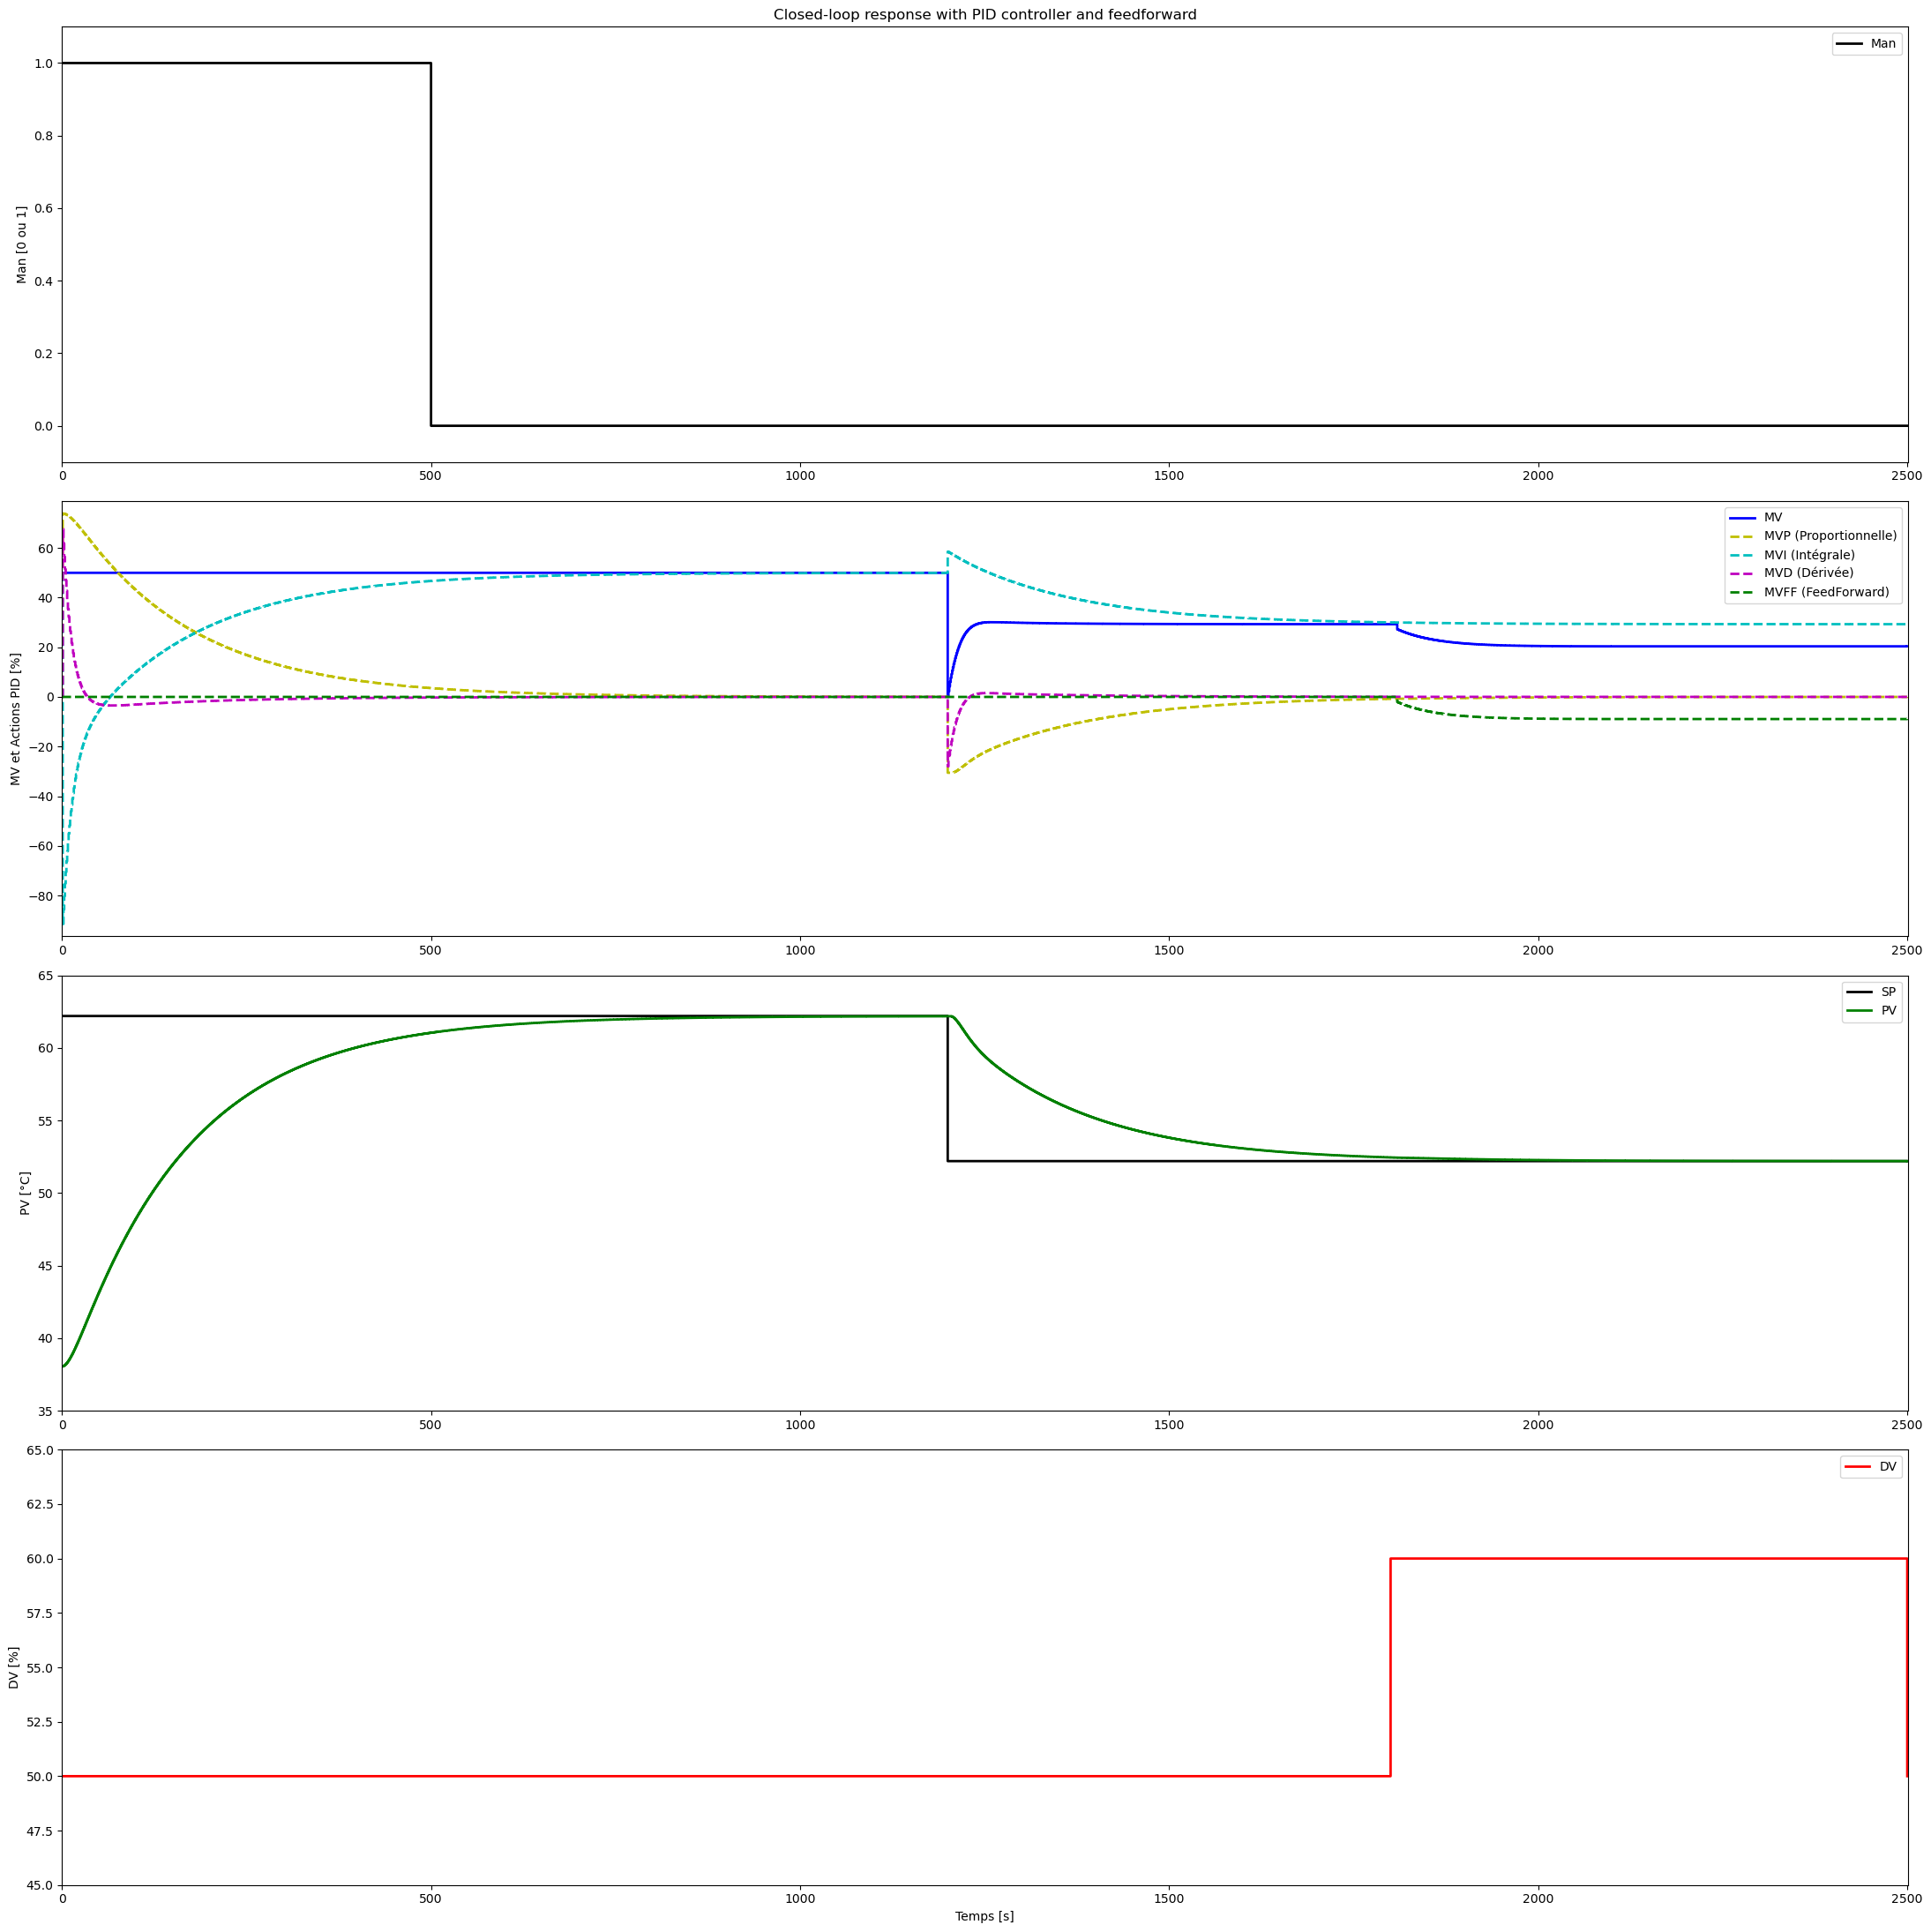

In [10]:

ManInt = [int(x) for x in Man]

fig, axs = plt.subplots(4, 1, figsize=(22, 22))

# Graphique pour Man
axs[0].step(t, ManInt, 'k-', linewidth=2, label='Man', where='post')
axs[0].set_ylabel('Man [0 ou 1]')
axs[0].set_title(Title_loop + ' response with PID controller and ' + Title_FF)
axs[0].legend(loc='best')
axs[0].set_xlim(0, t[-1] + 1)
axs[0].set_ylim(-0.1, 1.1)

# Graphique pour MV, MVP, MVI, MVD, et MVFF sur le même axe
axs[1].step(t, MV, 'b-', linewidth=2, label='MV', where='post')
axs[1].step(t, MVP, 'y--', linewidth=2, label='MVP (Proportionnelle)', where='post')
axs[1].step(t, MVI, 'c--', linewidth=2, label='MVI (Intégrale)', where='post')
axs[1].step(t, MVD, 'm--', linewidth=2, label='MVD (Dérivée)', where='post')
axs[1].step(t, MVFF, 'g--', linewidth=2, label='MVFF (FeedForward)', where='post')
axs[1].set_ylabel('MV et Actions PID [%]')
axs[1].legend(loc='best')
axs[1].set_xlim(0, t[-1] + 1)
axs[1].set_ylim(min(min(MV), min(MVP), min(MVI), min(MVD), min(MVFF)) - 5, max(max(MV), max(MVP), max(MVI), max(MVD), max(MVFF)) + 5)

# Graphique pour SP et PV
axs[2].step(t, SP, 'k-', linewidth=2, label='SP', where='post')
axs[2].step(t, PV, 'g-', linewidth=2, label='PV', where='post')
axs[2].set_ylabel('PV [°C]')
axs[2].legend(loc='best')
axs[2].set_xlim(0, t[-1] + 1)
axs[2].set_ylim(myRound(np.min((np.min(PV), np.min(SP))), 5) - 5, myRound(np.max((np.max(PV), np.max(SP))), 5) + 5)

# Graphique pour DV
axs[3].step(t, DV, 'r-', linewidth=2, label='DV', where='post')
axs[3].set_xlabel('Temps [s]')
axs[3].set_ylabel('DV [%]')
axs[3].legend(loc='best')
axs[3].set_xlim(0, t[-1] + 1)
axs[3].set_ylim(myRound(np.min(DV), 5) - 5, myRound(np.max(DV), 5) + 5)

plt.tight_layout()
nameFile = 'Plots/Simulation_' + Title_loop +'_' +Title_FF
plt.savefig(nameFile + '.png',transparent=True)            
plt.savefig(nameFile + '.pdf',transparent=True)
plt.show()